In [1]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import random
from detectron2.utils.file_io import PathManager
import xml.etree.ElementTree as ET
import numpy as np
%matplotlib inline

/nfs/stak/users/omorim/hpc-share/omorim/miniconda3/envs/detrex/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Randomly sample 10 images, and output the predictions, along with the labels as known/unknown

Read in predictions from csv file, and also the annotations, then put them on the images

In [2]:
df = pd.read_csv("predictions/agnostic_edges_test_predictions.csv", dtype={"ids":"str"})

In [3]:
df.head()

,Unnamed: 0,ids,probs,xmin,ymin,xmax,ymax
0,0,000001,0.564,1.3,8.9,353.0,500.0
1,1,000001,0.347,51.1,215.4,193.6,357.3
2,2,000001,0.197,51.9,215.1,194.1,379.3
3,3,000001,0.182,51.1,213.9,240.2,357.9
4,4,000001,0.178,50.9,213.3,240.1,357.8


In [4]:
df_known = pd.read_csv("t1_known_predictions_image.csv", dtype={"ids":"str"})

In [5]:
df_known.head()

,Unnamed: 0,ids,probs,xmin,ymin,xmax,ymax,labels
0,0,000000013659,0.912,366.8,288.5,488.8,480.0,chair
1,1,000000013659,0.774,479.5,175.7,587.2,323.5,chair
2,2,000000013659,0.502,190.3,127.2,261.0,199.9,chair
3,3,000000013659,0.382,286.8,217.2,329.3,312.3,chair
4,4,000000013659,0.347,305.5,146.4,400.9,255.8,chair


In [6]:
s = set(df["ids"].values)

In [7]:
VOC_CLASS_NAMES = [
"aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
"chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
"pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

In [27]:
def nms(bounding_boxes, confidence_score, threshold, labels):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []
    picked_labels = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])
        picked_labels.append(labels[index])
        
        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score, picked_labels

['000000280779',
 '000000160556',
 '009806',
 '000000341973',
 '000000013659',
 '000000081988',
 '003448',
 '008113',
 '009265',
 '000000148957']

In [9]:
# random.seed(0)
# r = random.sample(s, 10)
r = ['000000280779', '000000160556', '009806', '000000341973', '000000013659', '000000081988', '003448', '008113', '009265', '000000148957']

In [10]:
def parse_rec(filename):
    """Parse a PASCAL VOC xml file."""
    with PathManager.open(filename) as f:
        tree = ET.parse(f)
    objects = []
    for obj in tree.findall("object"):
        obj_struct = {}
        obj_struct["name"] = obj.find("name").text
        # This causes problems, because coco doesn't have pose annotations possibly
        #obj_struct["pose"] = obj.find("pose").text
        #obj_struct["truncated"] = int(obj.find("truncated").text)
        obj_struct["difficult"] = int(obj.find("difficult").text)
        bbox = obj.find("bndbox")
        obj_struct["bbox"] = [
            int(bbox.find("xmin").text),
            int(bbox.find("ymin").text),
            int(bbox.find("xmax").text),
            int(bbox.find("ymax").text),
        ]
        objects.append(obj_struct)

    return objects

In [18]:
i
new_df = df_known.loc[df['ids'] == r[i]]
new_df = new_df.loc[new_df['probs'] >= 0.4]
i

0

16
152
37


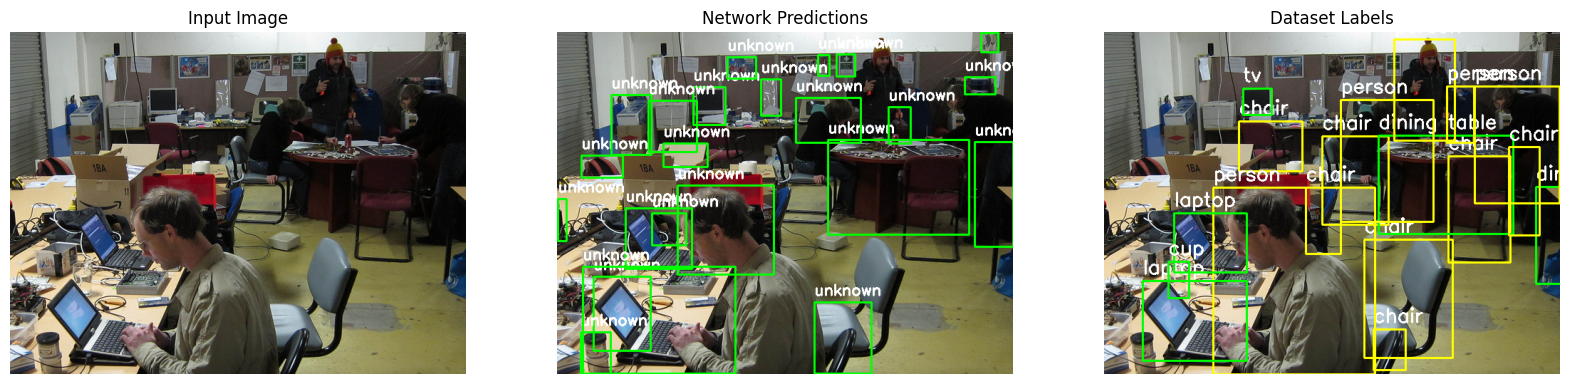

In [121]:
for i in range(len(r)):
    i = 4
    #i = 4
    new_df = df_known.loc[df_known['ids'] == r[i]]
    new_df = new_df.loc[new_df['probs'] >= 0.12]
    #new_df = df.loc[df['ids'] == r[i]]
    path = "../PROB/data/VOC2007/JPEGImages/{}.jpg".format(new_df["ids"].values[0])
    an_path = "../PROB/data/VOC2007/Annotations/{}.xml".format(new_df["ids"].values[0])
    o = parse_rec(an_path)
    image = cv2.imread(path)
    new_df.sort_values(by='probs', ascending=False)
    total = 0
    # Unknown predictions
    scores= new_df.probs.values
    known_labels = new_df.labels.values
    bounding_boxes = list(zip(new_df.xmin, new_df.ymin, new_df.xmax, new_df.ymax))
    boxes, scores, best_labels = nms(bounding_boxes, scores, 0.5, known_labels)
    print(len(scores))
    # print(len(boxes))
    # # for row in boxes:
    # #     total += 1
    # #     new_image = image
    # #     start = (int(row[0]), int(row[1]))
    # #     end = (int(row[2]), int(row[3]))
    # #     new_image = cv2.rectangle(image, start, end, color=(255,0,0), thickness=2)
    new_df = df.loc[df['ids'] == r[i]]
    new_df = new_df.loc[new_df['probs'] >= 0.13]
    scores2 = list(new_df.probs.values)
    bounding_boxes2 = list(zip(new_df.xmin, new_df.ymin, new_df.xmax, new_df.ymax))
    # don't get rid of knowns in nms
    scores = [x + 1 for x in scores]
    scores2.extend(scores)
    bounding_boxes2.extend(bounding_boxes)
    all_labels = ["unknown"] * len(new_df)
    all_labels.extend(known_labels)
    print(len(scores2))
    boxes, scores, all_labels = nms(bounding_boxes2, scores2, 0.4, all_labels)
    #all_labels = best_labels
    # print(len(boxes))
    print(len(scores))
    colors = {"unknown": (0, 255, 0), "people": (0, 255, 255), "chair": (0, 255, 255), "tv": (100, 100, 100)}
    for row, l in zip(boxes, all_labels):
        total += 1
        new_image = image
        start = (int(row[0]), int(row[1]))
        end = (int(row[2]), int(row[3]))
        if l not in VOC_CLASS_NAMES and l != "people":
            new_image = cv2.rectangle(image, start, end, color=colors[l], thickness=2)
            cv2.putText(image, l, (start[0], start[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    # for index, row in new_df.iterrows():
    #     #print(row)
    #     total += 1
    #     new_image = image
    #     start = (int(row["xmin"]), int(row["ymin"]))
    #     end = (int(row["xmax"]), int(row["ymax"]))
    #     new_image = cv2.rectangle(image, start, end, color=(255,0,0), thickness=2)
        # if total == 100:
        #     break
    image = cv2.imread(path)
    for object in o:
        start = (object["bbox"][0], object["bbox"][1])
        end = (object["bbox"][2], object["bbox"][3])
        co = (0, 255, 0)
        if object["name"] in VOC_CLASS_NAMES:
            co = (0, 255, 255)
            #new_image = cv2.rectangle(image, start, end, color=co, thickness=2)
            #cv2.putText(image, object["name"], (start[0], start[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
        true_image = cv2.rectangle(image, start, end, color=co, thickness=2)
        cv2.putText(image, object["name"], (start[0], start[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
    image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    f, axarr = plt.subplots(1,3, figsize=(20, 20))
    axarr[1].imshow(image_rgb, )
    # axarr[1].title.set_text('Predictions')
    image = cv2.imread(path)
    axarr[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axarr[0].axis('off')
    axarr[0].title.set_text('Input Image')
    axarr[1].title.set_text('Network Predictions')
    #plt.imshow(image_rgb)
    #plt.show()
    #plt.title("Predictions")
    axarr[2].imshow(cv2.cvtColor(true_image, cv2.COLOR_BGR2RGB))
    axarr[2].title.set_text('Dataset Labels')
    axarr[1].axis('off')
    plt.axis('off')
    #plt.title("green: prediction, blue: known label, red: unknown label")
    #plt.savefig("ground_truth_labels.png")
    break

In [33]:
len(o)

18

Find closest bounding box to each ground truth label and show it. Then show other predictions with NMS.

Only 9119 image ids? Some rows have 300 predictions for an imageid, some have 600??

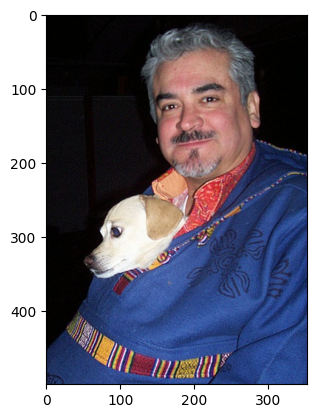

In [28]:
path = "../PROB/data/VOC2007/JPEGImages/000001.jpg"
image = cv2.imread(path)
new_image = image
# for i in range(300):
#     start = (int(df["xmin"][i]), int(df["ymin"][i]))
#     end = (int(df["xmax"][i]), int(df["ymax"][i]))
#     new_image = cv2.rectangle(image, start, end, color=(0,255,0), thickness=1)
image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.show()